In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

In [2]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# pylint: disable=invalid-name
# pylint: disable=missing-docstring
"""EfficientNet models for Keras.

Reference paper:
  - [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks]
    (https://arxiv.org/abs/1905.11946) (ICML 2019)
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import math

from tensorflow.python.keras import backend
from tensorflow.python.keras.applications import imagenet_utils
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.layers import VersionAwareLayers
from tensorflow.python.keras.utils import data_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io
from tensorflow.python.util.tf_export import keras_export


BASE_WEIGHTS_PATH = 'https://storage.googleapis.com/keras-applications/'

WEIGHTS_HASHES = {
    'b0': ('902e53a9f72be733fc0bcb005b3ebbac',
           '50bc09e76180e00e4465e1a485ddc09d'),
    'b1': ('1d254153d4ab51201f1646940f018540',
           '74c4e6b3e1f6a1eea24c589628592432'),
    'b2': ('b15cce36ff4dcbd00b6dd88e7857a6ad',
           '111f8e2ac8aa800a7a99e3239f7bfb39'),
    'b3': ('ffd1fdc53d0ce67064dc6a9c7960ede0',
           'af6d107764bb5b1abb91932881670226'),
    'b4': ('18c95ad55216b8f92d7e70b3a046e2fc',
           'ebc24e6d6c33eaebbd558eafbeedf1ba'),
    'b5': ('ace28f2a6363774853a83a0b21b9421a',
           '38879255a25d3c92d5e44e04ae6cec6f'),
    'b6': ('165f6e37dce68623721b423839de8be5',
           '9ecce42647a20130c1f39a5d4cb75743'),
    'b7': ('8c03f828fec3ef71311cd463b6759d99',
           'cbcfe4450ddf6f3ad90b1b398090fe4a'),
}

DEFAULT_BLOCKS_ARGS = [{
    'kernel_size': 3,
    'repeats': 1,
    'filters_in': 32,
    'filters_out': 16,
    'expand_ratio': 1,
    'id_skip': True,
    'strides': 1,
    'se_ratio': 0.25
}, {
    'kernel_size': 3,
    'repeats': 2,
    'filters_in': 16,
    'filters_out': 24,
    'expand_ratio': 6,
    'id_skip': True,
    'strides': 2,
    'se_ratio': 0.25
}, {
    'kernel_size': 5,
    'repeats': 2,
    'filters_in': 24,
    'filters_out': 40,
    'expand_ratio': 6,
    'id_skip': True,
    'strides': 2,
    'se_ratio': 0.25
}, {
    'kernel_size': 3,
    'repeats': 3,
    'filters_in': 40,
    'filters_out': 80,
    'expand_ratio': 6,
    'id_skip': True,
    'strides': 2,
    'se_ratio': 0.25
}, {
    'kernel_size': 5,
    'repeats': 3,
    'filters_in': 80,
    'filters_out': 112,
    'expand_ratio': 6,
    'id_skip': True,
    'strides': 1,
    'se_ratio': 0.25
}, {
    'kernel_size': 5,
    'repeats': 4,
    'filters_in': 112,
    'filters_out': 192,
    'expand_ratio': 6,
    'id_skip': True,
    'strides': 2,
    'se_ratio': 0.25
}, {
    'kernel_size': 3,
    'repeats': 1,
    'filters_in': 192,
    'filters_out': 320,
    'expand_ratio': 6,
    'id_skip': True,
    'strides': 1,
    'se_ratio': 0.25
}]

CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'truncated_normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

layers = VersionAwareLayers()

BASE_DOCSTRING = """Instantiates the {name} architecture.

  Reference:
  - [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](
      https://arxiv.org/abs/1905.11946) (ICML 2019)

  Optionally loads weights pre-trained on ImageNet.
  Note that the data format convention used by the model is
  the one specified in your Keras config at `~/.keras/keras.json`.
  If you have never configured it, it defaults to `"channels_last"`.

  Arguments:
    include_top: Whether to include the fully-connected
        layer at the top of the network. Defaults to True.
    weights: One of `None` (random initialization),
          'imagenet' (pre-training on ImageNet),
          or the path to the weights file to be loaded. Defaults to 'imagenet'.
    input_tensor: Optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
        if `include_top` is False.
        It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
        when `include_top` is `False`. Defaults to None.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
    classes: Optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified. Defaults to 1000 (number of
        ImageNet classes).
    classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        Defaults to 'softmax'.

  Returns:
    A `keras.Model` instance.
"""


def EfficientNet(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    activation='swish',
    blocks_args='default',
    model_name='efficientnet',
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'):
  """Instantiates the EfficientNet architecture using given scaling coefficients.

  Reference paper:
  - [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](
      https://arxiv.org/abs/1905.11946) (ICML 2019)

  Optionally loads weights pre-trained on ImageNet.
  Note that the data format convention used by the model is
  the one specified in your Keras config at `~/.keras/keras.json`.

  Arguments:
    width_coefficient: float, scaling coefficient for network width.
    depth_coefficient: float, scaling coefficient for network depth.
    default_size: integer, default input image size.
    dropout_rate: float, dropout rate before final classifier layer.
    drop_connect_rate: float, dropout rate at skip connections.
    depth_divisor: integer, a unit of network width.
    activation: activation function.
    blocks_args: list of dicts, parameters to construct block modules.
    model_name: string, model name.
    include_top: whether to include the fully-connected
        layer at the top of the network.
    weights: one of `None` (random initialization),
          'imagenet' (pre-training on ImageNet),
          or the path to the weights file to be loaded.
    input_tensor: optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
    input_shape: optional shape tuple, only to be specified
        if `include_top` is False.
        It should have exactly 3 inputs channels.
    pooling: optional pooling mode for feature extraction
        when `include_top` is `False`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
    classes: optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified.
    classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.

  Returns:
    A `keras.Model` instance.

  Raises:
    ValueError: in case of invalid argument for `weights`,
      or invalid input shape.
    ValueError: if `classifier_activation` is not `softmax` or `None` when
      using a pretrained top layer.
  """
  if blocks_args == 'default':
    blocks_args = DEFAULT_BLOCKS_ARGS

  if not (weights in {'imagenet', None} or file_io.file_exists(weights)):
    raise ValueError('The `weights` argument should be either '
                     '`None` (random initialization), `imagenet` '
                     '(pre-training on ImageNet), '
                     'or the path to the weights file to be loaded.')

  if weights == 'imagenet' and include_top and classes != 1000:
    raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                     ' as true, `classes` should be 1000')

  # Determine proper input shape
  input_shape = imagenet_utils.obtain_input_shape(
      input_shape,
      default_size=default_size,
      min_size=32,
      data_format=backend.image_data_format(),
      require_flatten=include_top,
      weights=weights)

  if input_tensor is None:
    img_input = layers.Input(shape=input_shape)
  else:
    if not backend.is_keras_tensor(input_tensor):
      img_input = layers.Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  def round_filters(filters, divisor=depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
      new_filters += divisor
    return int(new_filters)

  def round_repeats(repeats):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

  # Build stem
  x = img_input
  x = layers.Rescaling(1. / 255.)(x)
  x = layers.Normalization(axis=bn_axis)(x)

  x = layers.ZeroPadding2D(
      padding=imagenet_utils.correct_pad(x, 3),
      name='stem_conv_pad')(x)
  x = layers.Conv2D(
      round_filters(32),
      3,
      strides=2,
      padding='valid',
      use_bias=False,
      kernel_initializer=CONV_KERNEL_INITIALIZER,
      name='stem_conv')(x)
  #x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)#new
  x = layers.Activation(activation, name='stem_activation')(x)

  # Build blocks
  blocks_args = copy.deepcopy(blocks_args)

  b = 0
  blocks = float(sum(round_repeats(args['repeats']) for args in blocks_args))
  for (i, args) in enumerate(blocks_args):
    assert args['repeats'] > 0
    # Update block input and output filters based on depth multiplier.
    args['filters_in'] = round_filters(args['filters_in'])
    args['filters_out'] = round_filters(args['filters_out'])

    for j in range(round_repeats(args.pop('repeats'))):
      # The first block needs to take care of stride and filter size increase.
      if j > 0:
        args['strides'] = 1
        args['filters_in'] = args['filters_out']
      x = block(
          x,
          activation,
          drop_connect_rate * b / blocks,
          name='block{}{}_'.format(i + 1, chr(j + 97)),
          **args)
      b += 1

  # Build top
  x = layers.Conv2D(
      round_filters(1280),
      1,
      padding='same',
      use_bias=False,
      kernel_initializer=CONV_KERNEL_INITIALIZER,
      name='top_conv')(x)
  #x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)#new
  x = layers.Activation(activation, name='top_activation')(x)
  if include_top:
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    if dropout_rate > 0:
      x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    imagenet_utils.validate_activation(classifier_activation, weights)
    x = layers.Dense(
        classes,
        activation=classifier_activation,
        kernel_initializer=DENSE_KERNEL_INITIALIZER,
        name='predictions')(x)
  else:
    if pooling == 'avg':
      x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    elif pooling == 'max':
      x = layers.GlobalMaxPooling2D(name='max_pool')(x)

  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
    inputs = layer_utils.get_source_inputs(input_tensor)
  else:
    inputs = img_input

  # Create model.
  model = training.Model(inputs, x, name=model_name)

  # Load weights.
  if weights == 'imagenet':
    if include_top:
      file_suffix = '.h5'
      file_hash = WEIGHTS_HASHES[model_name[-2:]][0]
    else:
      file_suffix = '_notop.h5'
      file_hash = WEIGHTS_HASHES[model_name[-2:]][1]
    file_name = model_name + file_suffix
    weights_path = data_utils.get_file(
        file_name,
        BASE_WEIGHTS_PATH + file_name,
        cache_subdir='models',
        file_hash=file_hash)
    model.load_weights(weights_path, by_name=True,skip_mismatch=True)
  elif weights is not None:
    model.load_weights(weights)
  return model


def block(inputs,
          activation='swish',
          drop_rate=0.,
          name='',
          filters_in=32,
          filters_out=16,
          kernel_size=3,
          strides=1,
          expand_ratio=1,
          se_ratio=0.,
          id_skip=True):
  """An inverted residual block.

  Arguments:
      inputs: input tensor.
      activation: activation function.
      drop_rate: float between 0 and 1, fraction of the input units to drop.
      name: string, block label.
      filters_in: integer, the number of input filters.
      filters_out: integer, the number of output filters.
      kernel_size: integer, the dimension of the convolution window.
      strides: integer, the stride of the convolution.
      expand_ratio: integer, scaling coefficient for the input filters.
      se_ratio: float between 0 and 1, fraction to squeeze the input filters.
      id_skip: boolean.

  Returns:
      output tensor for the block.
  """
  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  # Expansion phase
  filters = filters_in * expand_ratio
  if expand_ratio != 1:
    x = layers.Conv2D(
        filters,
        1,
        padding='same',
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + 'expand_conv')(
            inputs)
    #x = layers.BatchNormalization(axis=bn_axis, name=name + 'expand_bn')(x)
    x = layers.Activation(activation, name=name + 'expand_activation')(x)
  else:
    x = inputs

  # Depthwise Convolution
  if strides == 2:
    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, kernel_size),
        name=name + 'dwconv_pad')(x)
    conv_pad = 'valid'
  else:
    conv_pad = 'same'
  x = layers.DepthwiseConv2D(
      kernel_size,
      strides=strides,
      padding=conv_pad,
      use_bias=False,
      depthwise_initializer=CONV_KERNEL_INITIALIZER,
      name=name + 'dwconv')(x)
  #x = layers.BatchNormalization(axis=bn_axis, name=name + 'bn')(x)
  x = layers.Activation(activation, name=name + 'activation')(x)

  # Squeeze and Excitation phase
  if 0 < se_ratio <= 1:
    filters_se = max(1, int(filters_in * se_ratio))
    se = layers.GlobalAveragePooling2D(name=name + 'se_squeeze')(x)
    se = layers.Reshape((1, 1, filters), name=name + 'se_reshape')(se)
    se = layers.Conv2D(
        filters_se,
        1,
        padding='same',
        activation=activation,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + 'se_reduce')(
            se)
    se = layers.Conv2D(
        filters,
        1,
        padding='same',
        activation='sigmoid',
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + 'se_expand')(se)
    x = layers.multiply([x, se], name=name + 'se_excite')

  # Output phase
  x = layers.Conv2D(
      filters_out,
      1,
      padding='same',
      use_bias=False,
      kernel_initializer=CONV_KERNEL_INITIALIZER,
      name=name + 'project_conv')(x)
  #x = layers.BatchNormalization(axis=bn_axis, name=name + 'project_bn')(x)#new
  if id_skip and strides == 1 and filters_in == filters_out:
    if drop_rate > 0:
      x = layers.Dropout(
          drop_rate, noise_shape=(None, 1, 1, 1), name=name + 'drop')(x)
    x = layers.add([x, inputs], name=name + 'add')
  return x


@keras_export('keras.applications.efficientnet.EfficientNetB0',
              'keras.applications.EfficientNetB0')
def EfficientNetB0(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.0,
      1.0,
      224,
      0.2,
      model_name='efficientnetb0',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB1',
              'keras.applications.EfficientNetB1')
def EfficientNetB1(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.0,
      1.1,
      240,
      0.2,
      model_name='efficientnetb1',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB2',
              'keras.applications.EfficientNetB2')
def EfficientNetB2(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.1,
      1.2,
      260,
      0.3,
      model_name='efficientnetb2',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB3',
              'keras.applications.EfficientNetB3')
def EfficientNetB3(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.2,
      1.4,
      300,
      0.3,
      model_name='efficientnetb3',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB4',
              'keras.applications.EfficientNetB4')
def EfficientNetB4(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.4,
      1.8,
      380,
      0.4,
      model_name='efficientnetb4',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB5',
              'keras.applications.EfficientNetB5')
def EfficientNetB5(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.6,
      2.2,
      456,
      0.4,
      model_name='efficientnetb5',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB6',
              'keras.applications.EfficientNetB6')
def EfficientNetB6(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      1.8,
      2.6,
      528,
      0.5,
      model_name='efficientnetb6',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


@keras_export('keras.applications.efficientnet.EfficientNetB7',
              'keras.applications.EfficientNetB7')
def EfficientNetB7(include_top=True,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=None,
                   pooling=None,
                   classes=1000,
                   classifier_activation='softmax',
                   **kwargs):
  return EfficientNet(
      2.0,
      3.1,
      600,
      0.5,
      model_name='efficientnetb7',
      include_top=include_top,
      weights=weights,
      input_tensor=input_tensor,
      input_shape=input_shape,
      pooling=pooling,
      classes=classes,
      classifier_activation=classifier_activation,
      **kwargs)


EfficientNetB0.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB0')
EfficientNetB1.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB1')
EfficientNetB2.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB2')
EfficientNetB3.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB3')
EfficientNetB4.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB4')
EfficientNetB5.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB5')
EfficientNetB6.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB6')
EfficientNetB7.__doc__ = BASE_DOCSTRING.format(name='EfficientNetB7')


@keras_export('keras.applications.efficientnet.preprocess_input')
def preprocess_input(x, data_format=None):  # pylint: disable=unused-argument
  return x


@keras_export('keras.applications.efficientnet.decode_predictions')
def decode_predictions(preds, top=5):
  return imagenet_utils.decode_predictions(preds, top=top)


decode_predictions.__doc__ = imagenet_utils.decode_predictions.__doc__

backbone = keras.applications.ResNet50(include_top=False, input_shape=[64, 64, 3])
#["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
backbone.summary()

backbone = keras.applications.ResNet50V2(include_top=False, input_shape=[64, 64, 3])
backbone.summary()

#backbone = keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
backbone = keras.applications.EfficientNetB0(include_top=False, input_shape=[64, 64, 3])
#["block3b_add", "block4c_add", "block6d_add"]]
backbone.summary()

backbone = keras.applications.EfficientNetB0(include_top=False, input_shape=[64, 64, 3])
c3_output, c4_output, c5_output = [
    backbone.get_layer(layer_name).output
    for layer_name in ["block3b_add", "block4c_add", "block6d_add"]]

c3_output, c4_output, c5_output = [
    backbone.get_layer(layer_name).output
    for layer_name in ["block3b_add", "block4c_add", "block6d_add"]]
    #for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
model =  keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]    )

In [3]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.1', True)

In [4]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [5]:
padded_image_shape = (1024, 1920)
anchor_k = 9
num_classes_real = 5
num_classes = num_classes_real*2#
max_data_m = 50#00
use_zoom_up_data = False
level_start = 4
level_end = 5
l1 = 1e-9
activation = 'swish'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
class_names = ['bg', '"water"', '"waterf"', '"land"', '"animal"']

folder_water_image = folder_image = '/home/mvlab/Downloads/dataset/water/'
path_csv = folder_water_image + 'via_project_20200914.csv'
folder_weather = '/home/mvlab/Downloads/dataset/weather/'
path_weight = "retinanet/water_efficient_det_BiFPN_D2_no_BN"
folder_water_bg = '/home/mvlab/Downloads/dataset/water_movie/bg/'

os.path.isdir(folder_water_image), os.path.isfile(path_csv), os.path.isdir(folder_water_bg)

(True, True, True)

In [6]:
folder_ped = '/home/mvlab/Downloads/dataset/PennFudanPed/'
folder_ped_rgb = 'PNGImages/'
folder_ped_mask = 'PedMasks/'

is_Penn_exist = os.path.isdir(folder_ped)
os.path.isdir(folder_ped), os.path.isdir(folder_ped+folder_ped_rgb), os.path.isdir(folder_ped+folder_ped_mask)

(False, False, False)

In [7]:
def convert_path_rgb_to_path_mask(path_rgb):
    path_file_name = path_rgb.split('/')[-1]
    file_name_pre = path_file_name.split('.')[0]
    path_mask = folder_ped + folder_ped_mask + file_name_pre + '_mask' + '.png'
    if os.path.isfile(path_mask):
        return path_mask
    else:
        print('not exist file', path_mask)
        exit()

In [8]:
path_rgbs = glob(folder_ped + folder_ped_rgb + '*.*')
len(path_rgbs), path_rgbs[0], path_rgbs[-1]
path_masks = []
for path_rgb in path_rgbs:
    path_masks.append(convert_path_rgb_to_path_mask(path_rgb))
print(len(path_rgbs), len(path_masks))
plt.imshow(Image.open(path_masks[0]))

IndexError: list index out of range

In [9]:
def get_masked_pedestrian(path_rgbs, path_masks):
    arr_ped_list = []
    m = len(path_rgbs)
    for i in range(m):
        path_rgb = path_rgbs[i]
        path_mask = path_masks[i]
        img_rgb = Image.open(path_rgb)
        img_rgb = img_rgb.filter(ImageFilter.GaussianBlur(radius=3))
        img_mask = Image.open(path_mask)
        arr_rgb = np.array(img_rgb)
        arr_mask = np.array(img_mask)
        mask_max_v = np.max(arr_mask)
        img_h, img_w = arr_mask.shape
        #print(i, 'mask_max_v', mask_max_v, np.unique(arr_mask), 'img_h, img_w', img_h, img_w)
        if np.min(arr_rgb) < 1:
            #print('rgb min value is', np.min(arr_rgb), np.max(arr_rgb), path_rgb)
            arr_rgb = np.maximum(arr_rgb, np.ones_like(arr_rgb))
            
        arr_mask_3d = np.expand_dims((arr_mask > 0).astype(np.uint8), -1)
        arr_rgb_masked = arr_rgb * arr_mask_3d
        for j in range(1, 1 + mask_max_v):
            ped_mask_j = arr_mask == j
            ped_mask_sum_0 = np.any(ped_mask_j, axis=0)
            ped_mask_sum_1 = np.any(ped_mask_j, axis=1)
            ped_mask_sum_0 = ped_mask_sum_0.astype(np.int)
            ped_mask_sum_1 = ped_mask_sum_1.astype(np.int)
           
            x0 = np.argmax(ped_mask_sum_0)
            x1 = img_w - np.argmax(ped_mask_sum_0[::-1])
            y0 = np.argmax(ped_mask_sum_1)
            y1 = img_h - np.argmax(ped_mask_sum_1[::-1])            
            #print(ped_mask_j.shape, np.sum(ped_mask_j), x0, x1, y0, y1)            
            arr_ped_j = arr_rgb_masked[y0:y1, x0:x1]
            arr_ped_list.append(arr_ped_j)
        
        if i%100==0:print(i, len(arr_ped_list))
    return arr_ped_list

In [10]:
ped_list = get_masked_pedestrian(path_rgbs, path_masks)
print('len', len(ped_list))
p = plt.imshow(ped_list[2]) 

NameError: name 'path_masks' is not defined

In [11]:
folder_water_image, os.path.isdir(folder_water_image)

('/home/mvlab/Downloads/dataset/water/', True)

(1920, 1080)


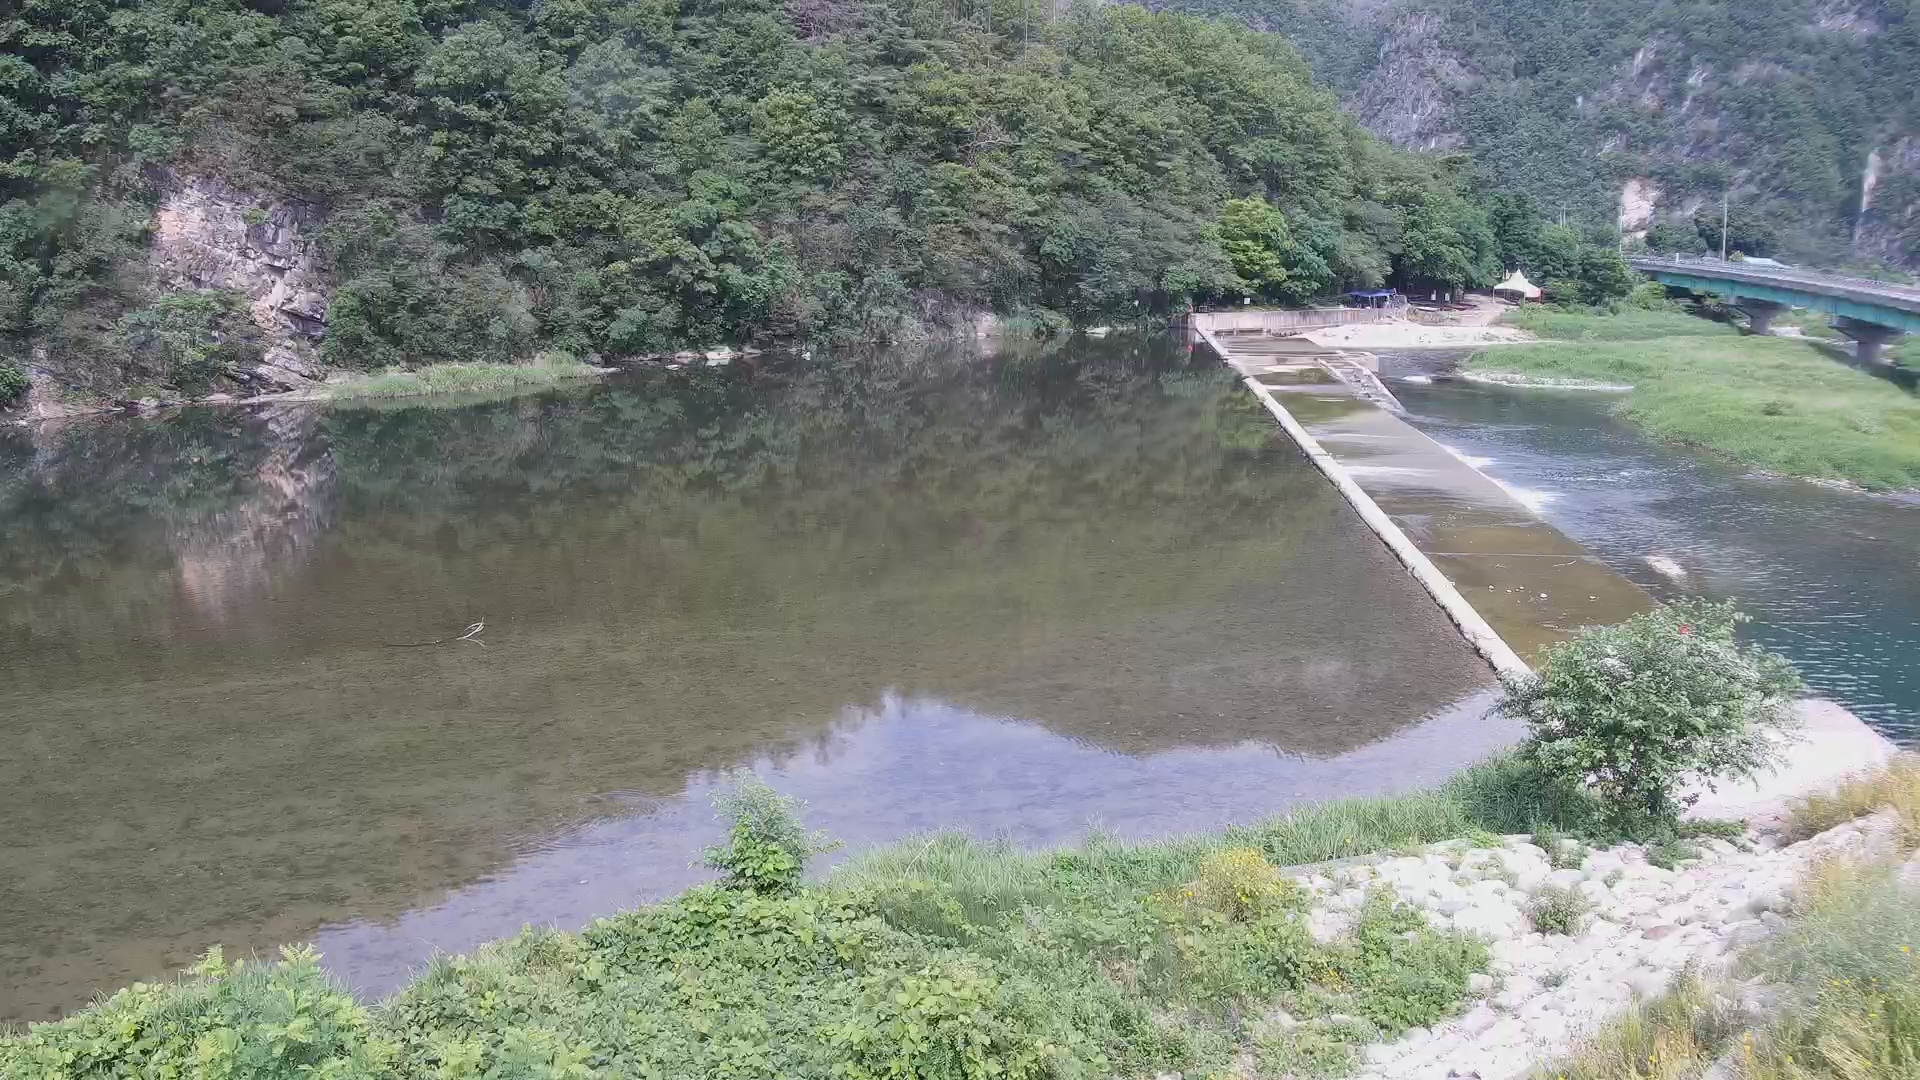

In [12]:
img_water_path = folder_water_image + '00222.png'
img_water = Image.open(img_water_path)
print(img_water.size)
img_water

In [13]:
def append_pedestrin_to_water(ped_arrs, img_water, range_width = (14, 30)):
    m = len(ped_arrs)
    water_arr = np.array(img_water)
    mask_arr = np.zeros_like(water_arr[:, :, 0])
    labels = []
    img_h, img_w, img_c = water_arr.shape
    top_offset_y0 = int(img_h * 0.03) 
    top_offset_y1 = int(img_h * 0.25) 
    top_offset_x0 = int(img_w * 0.03) 
    top_offset_x1 = int(img_w * 0.9) 
    water_offset_y0 = int(img_h * 0.4) 
    water_offset_y1 = int(img_h * 0.8) 
    water_offset_x0 = int(img_w * 0.03) 
    water_offset_x1 = int(img_w * 0.65) 
    land_offset_y0 = int(img_h * 0.91) 
    land_offset_y1 = int(img_h * 0.98) 
    land_offset_x0 = int(img_w * 0.05) 
    land_offset_x1 = int(img_w * 0.95)         
    
    last_i = 0
    def append_object(offset_x0, offset_x1, offset_y0, offset_y1, cls, last_i, is_crop=False):
        tx = 0
        ty = 0
        for i in range(last_i, m):
            ped_arr = ped_arrs[i]
            #print(i, ped_arr.shape)
            ped_h = ped_arr.shape[0]
            ped_h_a = 1.0 + offset_y0/img_h
            if is_crop:
                ped_h_a = 1.0
                ped_arr = ped_arr[:ped_h//2]
                
            ped_img = Image.fromarray(ped_arr)
            ped_w = np.random.randint(range_width[0], range_width[1])
            ped_h = int(ped_w * ped_h_a)

            ped_img = ped_img.resize((ped_w, ped_h))
            #ped_img = ped_img.filter(ImageFilter.GaussianBlur(radius=3))
            ped_arr = np.array(ped_img)
            y0 = offset_y0 + ty
            y1 = y0 + ped_h
            x0 = offset_x0 + tx
            x1 = x0 + ped_w
            water_crop = water_arr[y0:y1, x0:x1]
            ped_mask = (ped_arr > 1).astype(np.uint8)
            #print('ped_arr', ped_arr.shape, 'water_crop', water_crop.shape)
            try:
                ped_arr = ped_arr + water_crop * (1 - ped_mask)
            except:
                print('ped_arr', ped_arr.shape, 'water_crop', water_crop.shape)
                break
                
            water_arr[y0:y1, x0:x1] = ped_arr
            mask_arr[y0:y1, x0:x1] = ped_mask[:, :, 0]
            waterf = cls
            margin = 2
            bx0 = 1.0 * (x0 - margin)/img_w
            by0 = 1.0 * (y0 - margin)/img_h
            bx1 = 1.0 * (x1 + margin)/img_w
            by1 = 1.0 * (y1 + margin)/img_h
            cbbox = np.array([waterf, bx0, by0, bx1, by1])
            labels.append(cbbox)

            tx += int((x1 - x0) * 1.8)
            if tx > offset_x1:
                tx = 0
                ty += int(range_width[1]*1.9)

            if offset_y0 + ty > offset_y1*0.95:
                last_i = i
                print(m, last_i, 'break')
                break
        return last_i
    
    last_i = append_object(top_offset_x0, top_offset_x1, top_offset_y0, top_offset_y1, 3, last_i)
    last_i = append_object(water_offset_x0, water_offset_x1, water_offset_y0, water_offset_y1, 2, last_i, is_crop=True)
    last_i = append_object(land_offset_x0, land_offset_x1, land_offset_y0, land_offset_y1, 3, last_i)
    
    
    labels = np.stack(labels)
    mask_bool = mask_arr.astype(np.bool)
    return water_arr, mask_bool, labels

In [14]:
water_with_ped, water_mask, mask_cbbox = append_pedestrin_to_water(ped_list, img_water,range_width = (24, 42))
water_with_ped = np.expand_dims(water_with_ped, 0)
water_mask = np.expand_dims(water_mask, 0)
mask_cbbox = np.expand_dims(mask_cbbox, 0)
print('mask_cbbox', len(mask_cbbox))
plt.figure(figsize=(12,10))
plt.imshow(water_with_ped[0])

NameError: name 'ped_list' is not defined

In [ ]:
print('water_mask', water_mask.shape, water_mask.dtype)
plt.imshow(water_mask[0])

In [15]:
use_weather_effect = os.path.isdir(folder_weather)
use_weather_effect, folder_weather

(False, '/home/mvlab/Downloads/dataset/weather/')

In [16]:
img_paths = glob(folder_water_image + '*.*')
len(img_paths)

1294

In [17]:
weather_images = []
if use_weather_effect:
    path_weathers = glob(folder_weather + '*.*')
    if len(path_weathers)>0:
        for path_weather in path_weathers:            
            image = Image.open(path_weather) 
            weather_images.append(image)            
            plt.imshow(image)
            plt.show()

In [18]:
df = pd.read_csv(path_csv)
df.shape, path_csv

((3308, 7), '/home/mvlab/Downloads/dataset/water/via_project_20200914.csv')

In [19]:
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,00001.png,3697347,{},5,0,"{""name"":""rect"",""x"":1472,""y"":735,""width"":25,""he...","{""object"":{""waterf"":true}}"
1,00001.png,3697347,{},5,1,"{""name"":""rect"",""x"":1735,""y"":627,""width"":21,""he...","{""object"":{""water"":true}}"
2,00001.png,3697347,{},5,2,"{""name"":""rect"",""x"":1501,""y"":461,""width"":20,""he...","{""object"":{""water"":true}}"
3,00001.png,3697347,{},5,3,"{""name"":""rect"",""x"":1339,""y"":407,""width"":13,""he...","{""object"":{""water"":true}}"
4,00001.png,3697347,{},5,4,"{""name"":""rect"",""x"":1356,""y"":408,""width"":14,""he...","{""object"":{""water"":true}}"


In [20]:
df['filename'].nunique()

1355

In [21]:
annotation = dict()
no_key_m = 0
for i in range(len(df)):
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
    box_map = ast.literal_eval(box)
         
    cls = 0
    for j in range(len(class_names)):        
        if class_names[j] in region_attributes:
            cls = j
            break
            
    #print(i, df.loc[i, 'filename'], box_map)
    if len(box_map.keys())<1:
        no_key_m+=1
        print(i, no_key_m, 'no_keys_skip', filename)                
        cls = -1
        box_map = {'x':0, 'y':0, 'width':5, 'height':5}
        continue
                
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
    x1 = x0 + width
    y1 = y0 + height
    if True:
        margin = 2
        #print('margin', width, margin)
        x0 -= margin
        y0 -= margin
        x1 += margin
        y1 += margin
    
    bbox = [cls, x0, y0, x1, y1]
    
    if region_id > 0:
        annotation[filename].extend(bbox)
    else:
        annotation[filename] = bbox
    
    #print(i, df.loc[i, 'filename'], width, height)

585 1 no_keys_skip 00222.png
622 2 no_keys_skip 00250.png
662 3 no_keys_skip 00283.png
663 4 no_keys_skip 00284.png
666 5 no_keys_skip 00287.png
835 6 no_keys_skip 00357.png
836 7 no_keys_skip 00358.png
837 8 no_keys_skip 00359.png
838 9 no_keys_skip 00360.png
869 10 no_keys_skip 00391.png
971 11 no_keys_skip 00434.png
1031 12 no_keys_skip 00460.png
1033 13 no_keys_skip 00462.png
1078 14 no_keys_skip 00473.png
1494 15 no_keys_skip 00578.png
2310 16 no_keys_skip 00752.png
2311 17 no_keys_skip 00753.png
2345 18 no_keys_skip 00778.png
2346 19 no_keys_skip 00779.png
2347 20 no_keys_skip 00780.png
2348 21 no_keys_skip 00781.png
2349 22 no_keys_skip 00782.png
2350 23 no_keys_skip 00783.png
2351 24 no_keys_skip 00784.png
2352 25 no_keys_skip 00785.png
2353 26 no_keys_skip 00786.png
2354 27 no_keys_skip 00787.png
2355 28 no_keys_skip 00788.png
2356 29 no_keys_skip 00789.png
2357 30 no_keys_skip 00790.png
2358 31 no_keys_skip 00791.png
2359 32 no_keys_skip 00792.png
2360 33 no_keys_skip 00793.p

In [22]:
plt.title(str(np.mean(object_width_list)))
plt.hist(object_width_list)

NameError: name 'object_width_list' is not defined

In [23]:
folder_image

'/home/mvlab/Downloads/dataset/water/'

In [24]:
input_list = []
bbox_list = []
path_list = []
for key in annotation:
    cls_bbox = annotation[key]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
    is_rgb = 1
        
    path_image = folder_image + key
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))
        
        if img.width < 1300:#1280 or 1960
            is_rgb = 0
            #print(i, 'img.width', img.width)
       
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(key)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
    else:
        print('not exist', path_image)

print(len(input_list), len(bbox_list))

1194 100 100
1194 200 200
1194 300 300
1194 400 400
1194 500 500
1194 600 600
1194 700 700
1194 800 800
1194 900 900
1194 1000 1000
1194 1100 1100
not exist /home/mvlab/Downloads/dataset/water/0108.png
not exist /home/mvlab/Downloads/dataset/water/0109.png
not exist /home/mvlab/Downloads/dataset/water/0110.png
not exist /home/mvlab/Downloads/dataset/water/0113.png
not exist /home/mvlab/Downloads/dataset/water/0129.png
not exist /home/mvlab/Downloads/dataset/water/0140.png
1188 1188


(3133, 5)


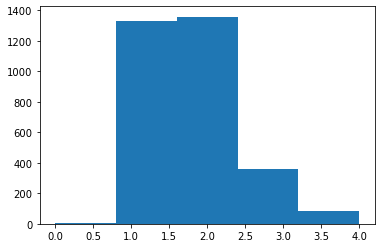

In [25]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0], bins=len(class_names))

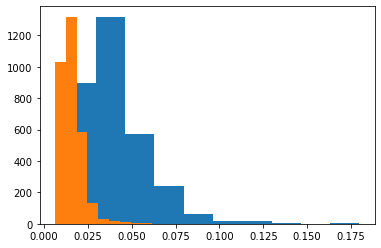

In [26]:
box_w = cbbox[:, -2] - cbbox[:, -4]
box_h = cbbox[:, -1] - cbbox[:, -3]
h = plt.hist(box_h)
h = plt.hist(box_w)

In [27]:
 np.corrcoef(box_w, box_h)

array([[1.        , 0.49140354],
       [0.49140354, 1.        ]])

In [28]:
box_y = cbbox[:, -1]
box_x = cbbox[:, -2]
box_size = np.sqrt(box_w * box_h)
np.corrcoef(box_y, box_x), np.corrcoef(box_x, box_h), np.corrcoef(box_y, box_h)

(array([[1.       , 0.4089439],
        [0.4089439, 1.       ]]),
 array([[1.       , 0.2183088],
        [0.2183088, 1.       ]]),
 array([[1.        , 0.45251583],
        [0.45251583, 1.        ]]))

In [29]:
np.correlate(box_x, box_h), np.corrcoef(box_x, box_h)[1, 0]

(array([78.53585632]), 0.21830879730454442)

In [30]:
np.corrcoef(box_x, box_size)[1, 0], np.corrcoef(box_y, box_size)[1, 0]

(0.2012703785074394, 0.4751891115753328)

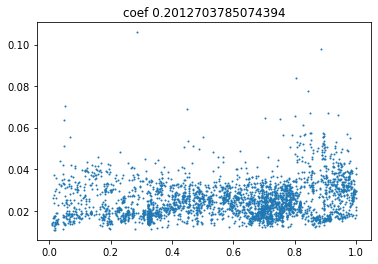

In [31]:
plt.title('coef '+ str(np.corrcoef(box_x, box_size)[1, 0]))
plt.scatter(box_x, box_size, s=1)

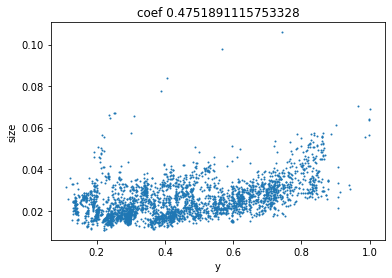

In [32]:
plt.title('coef '+ str(np.corrcoef(box_y, box_size)[1, 0]))
plt.xlabel('y')
plt.ylabel('size')
plt.scatter(box_y, box_size, s=1)

In [33]:
cbbox.shape

(3133, 5)

In [34]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [35]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [36]:
def tile_object(X, BBOX, scope=0.5):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        if not np.any(cls>0):
            continue
            
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            
            cx = np.mean((box_x_min + box_x_max)/2)
            
            if cx < 0.5:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            else:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
                        
            tbox = np.stack((cls, (x0 - tx0)/scope, y0, (x1 - tx0)/scope, y1), axis=1)            
            
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[:, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            img_resized = img.resize((padded_image_shape[1]//2, padded_image_shape[0]))
            arr_resized = np.array(img_resized)            
            
            crop_xs.append(arr_resized)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [37]:
def attach_tiled_data(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        bg_color = np.median(X[i])
        attach_xs.append(bg_color + np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = i#m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        cls, x0, y0, x1, y1 = np.split(bbox, 5, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((cls, x0, y0, x1, y1), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [38]:
folder_water_bg

'/home/mvlab/Downloads/dataset/water_movie/bg/'

In [39]:
13%10

3

In [40]:
def attach_with_bg(X, BBOX):
    m = len(X)
    list_bg_jpg = glob(folder_water_bg + '*')
    attach_xs = []
    attach_bboxs = []
    
    for i in range(len(list_bg_jpg)):
        obj_i = (i*2)%m
        
        bg_img = Image.open(list_bg_jpg[i])
        bg_img = bg_img.resize((padded_image_shape[1], padded_image_shape[0]))
        bg_arr = np.array(bg_img)
        bg_l, bg_r = np.split(bg_arr, 2, axis=1)
        
        attach_xs.append(np.concatenate((X[obj_i], bg_r), axis=1))
        c, x0, y0, x1, y1 = np.split(BBOX[obj_i], 5, -1)
        bbox = np.concatenate((c, x0*0.5, y0, x1*0.5, y1), -1)
        attach_bboxs.append(bbox)
        
        attach_xs.append(np.concatenate((bg_l, X[obj_i+1]), axis=1))
        c, x0, y0, x1, y1 = np.split(BBOX[obj_i+1], 5, -1)
        bbox = np.concatenate((c, 0.5+x0*0.5, y0, 0.5+x1*0.5, y1), -1)
        attach_bboxs.append(bbox)
        
    return attach_xs, attach_bboxs

In [41]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h = x.shape[0]
        img_w = x.shape[1]
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X
    
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        box = bbox[:, 1:]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))
        
        angle = angle + np.random.normal(scale=np.abs(angle))
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

In [42]:
def crop_obj(X, Y):
    crop_obj_list = []
    shape_list = []
    cls_list = []
    for i in range(len(X)):        
        x = X[i]        
        bboxs = Y[i]
        img_h, img_w, img_c = x.shape
        for j in range(len(bboxs)):
            box = bboxs[j]
            #print('box', box)
            cls, x0, y0, x1, y1 = list(box)
            x0 = int(x0 * img_w)
            x1 = int(x1 * img_w)            
            y0 = int(y0 * img_h)
            y1 = int(y1 * img_h)
            
            x_crop = x[y0:y1, x0:x1]
            if np.min(x_crop.shape)<3:
                continue
            crop_obj_list.append(x_crop)
            cls_list.append(cls)
            shape_list.append((x1-x0, y1-y0))
        
    return crop_obj_list, cls_list, shape_list

def attach_obj(crop_obj_list, cls_list, resize_w=32, resize_h=48):
    m = len(crop_obj_list)    
    img_h = padded_image_shape[0]
    img_w = padded_image_shape[1]
    row = img_h//resize_h
    col = img_w//resize_w
    img_m = (m - 1) // (row * col) + 1
    canvas = np.zeros((img_m, img_h, img_w, 3), dtype=np.uint8)
    cbbox_list = []
    for i in range(img_m):
        cbbox_list.append([])
    print('canvas', canvas.shape, row, col)
    cls_sort_index = np.argsort(cls_list)
    for j in range(m):
        i = cls_sort_index[j]
        x = crop_obj_list[i]
        cls = cls_list[i]
        #print(i, x.shape)
        arr = x.astype(np.uint8)
        img = Image.fromarray(arr)
        img = img.resize((resize_w, resize_h))
        x = np.array(img)
        tm = i // (row * col)
        ty = (i % (row * col) )// col
        tx = i % col
        #print(i, tm, ty, tx)
        x0 = tx*resize_w
        x1 = (tx+1)*resize_w
        y0 = ty*resize_h
        y1 = (ty+1)*resize_h
        canvas[tm, y0:y1, x0:x1] = x
        
        cbbox_list[tm].append(np.array([cls, 1.0*x0/img_w, 1.0*y0/img_h, 1.0*x1/img_w, 1.0*y1/img_h]))
        
    for i in range(img_m):
        cbboxs = cbbox_list[i]
        cbbox_list[i] = np.stack(cbboxs, axis=0)
    return canvas, cbbox_list


In [43]:
m = len(input_list)
print('m', m)
s=1
input_list_train = input_list[::s]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::s]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

m 1188
bbox_list_train 1188 1188 594


#water_with_ped, water_mask, mask_cbbox
water_with_ped_0, mask_cbbox_0 = gen_rotate_data(water_with_ped, mask_cbbox, angle=0.5)
water_mask_0 = rotate_images(water_mask, angle=1.5)
water_with_ped_1, mask_cbbox_1 = gen_rotate_data(water_with_ped, mask_cbbox, angle=-0.5)
water_mask_1 = rotate_images(water_mask, angle=-1.5)
print('mask_cbbox_0', mask_cbbox[0][0], mask_cbbox_0[0][0])
plt.imshow(water_with_ped_1[0])

water_with_ped = np.concatenate((water_with_ped_0, water_with_ped_1, water_with_ped), 0)
water_mask = np.concatenate((water_mask_0, water_mask_1, water_mask), 0)
mask_cbbox = np.concatenate((mask_cbbox_0, mask_cbbox_1, mask_cbbox), 0)
print('shape', water_with_ped.shape, water_mask.shape, mask_cbbox.shape )

img_objects, cls_list, shape_list = crop_obj(input_list_train, bbox_list_train)
print('len(img_objects)', len(img_objects), len(cls_list), img_objects[0].dtype)
print('shape_list', np.mean(np.stack(shape_list, 0), 0))

img_0 = rotate_images(img_objects, angle=1)
img_1 = rotate_images(img_objects, angle=-1)
img_2 = rotate_images(img_objects, angle=2)
img_3 = rotate_images(img_objects, angle=-2)
img_4 = rotate_images(img_objects, angle=3)
img_5 = rotate_images(img_objects, angle=-3)

img_objects = np.concatenate((img_objects, img_0, img_1, img_2, img_3, img_4, img_5), 0)
cls_list_original = cls_list.copy()
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
cls_list.extend(cls_list_original)
print(len(img_objects), len(cls_list))

attach_obj_img, attach_obj_bbox = attach_obj(img_objects, cls_list)
print('attach_obj_img', attach_obj_img.shape, len(attach_obj_bbox), len(attach_obj_bbox[0]))

display_data(attach_obj_img, attach_obj_bbox, stride=10)

attach_obj_img1, attach_obj_bbox1 = attach_obj(img_objects, cls_list, resize_w=26, resize_h=42)
print('attach_obj_img1', len(attach_obj_img1), len(attach_obj_bbox1[0]))
display_data(attach_obj_img1, attach_obj_bbox1, stride=5)

attach_obj_img2, attach_obj_bbox2 = attach_obj(img_objects, cls_list, resize_w=36, resize_h=55)
print('attach_obj_img2', len(attach_obj_img2), len(attach_obj_bbox2[0]))
display_data(attach_obj_img2, attach_obj_bbox2, stride=10)

attach_obj_img = np.concatenate((attach_obj_img, attach_obj_img1, attach_obj_img2), axis=0)
attach_obj_bbox.extend(attach_obj_bbox1)
attach_obj_bbox.extend(attach_obj_bbox2)
print('len', len(attach_obj_img), len(attach_obj_bbox))

plt.imshow(img_objects[0].astype(np.uint8))

In [ ]:
crop_xs, crop_bboxs = tile_object(input_list_train, bbox_list_train)
print('crop_xs', len(crop_xs), len(crop_bboxs), crop_xs[0].shape, crop_bboxs[0])
#display_data(crop_xs, crop_bboxs, stride=100)

In [ ]:
rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=0.5)
rotate_xs_1, rotate_bboxs_1 = gen_rotate_data(crop_xs, crop_bboxs, angle=-1.0)

print('rotate_xs', len(rotate_xs), len(rotate_bboxs))
rotate_xs.extend(rotate_xs_1)
rotate_bboxs.extend(rotate_bboxs_1)

print('crop_xs', len(crop_xs), len(rotate_xs))

In [ ]:
attach_xs, attach_bboxs = attach_with_bg(rotate_xs, rotate_bboxs)

In [ ]:
len(attach_xs), len(attach_bboxs)

rotate_xs, rotate_bboxs = gen_rotate_data(crop_xs, crop_bboxs, angle=1.0)
rotate_xs_1, rotate_bboxs_1 = gen_rotate_data(crop_xs, crop_bboxs, angle=-1.0)

print('rotate_xs', len(rotate_xs), len(rotate_bboxs))
rotate_xs.extend(rotate_xs_1)
rotate_bboxs.extend(rotate_bboxs_1)

print('crop_xs', len(crop_xs), len(rotate_xs))

rotate_xs_2, rotate_bboxs_2 = gen_rotate_data(crop_xs, crop_bboxs, angle=2.5)
rotate_xs_3, rotate_bboxs_3 = gen_rotate_data(crop_xs, crop_bboxs, angle=-2.5)
rotate_xs.extend(rotate_xs_2)
rotate_bboxs.extend(rotate_bboxs_2)
rotate_xs.extend(rotate_xs_3)
rotate_bboxs.extend(rotate_bboxs_3)

In [ ]:
display_data(attach_xs, attach_bboxs, stride=501)

display_data(crop_xs, crop_bboxs, stride=10)

display_data(input_list, bbox_list, stride=500)

In [ ]:
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

In [ ]:
use_zoom_up_data

In [ ]:
stride = len(input_list_train) // len(attach_xs)
stride = max(1, stride)
for i in range(len(attach_xs)):
    input_list_train.insert(i*stride, attach_xs.pop())
    bbox_list_train.insert(i*stride, attach_bboxs.pop())
if use_zoom_up_data:
    for i in range(len(crop_xs)):
        input_list_train.insert(1+i*stride, crop_xs.pop())
        bbox_list_train.insert(1+i*stride, crop_bboxs.pop())
print('len', len(input_list_train), len(crop_xs), len(attach_xs))

stride = len(input_list_train) // len(attach_obj_img)
for i in range(len(attach_obj_img)):    
    input_list_train.insert(i*stride, attach_obj_img[i])
    bbox_list_train.insert(i*stride, attach_obj_bbox[i])

print('len', len(input_list_train), len(attach_obj_img))

stride = 100
ped_k = len(water_with_ped)
for i in range(len(input_list_train)//stride):     
    idx = i%ped_k
    input_list_train.insert(i*stride, water_with_ped[idx])
    bbox_list_train.insert(i*stride, mask_cbbox[idx])
    
print(len(input_list_train), len(bbox_list_train))

input_list_train.extend(list_visdrone_image_arr)
input_list_test.extend(list_visdrone_image_arr)
bbox_list_train.extend(list_visdrone_cbbox)
bbox_list_test.extend(list_visdrone_cbbox)

bg_list = glob(folder_water_bg+'*')

stride = max(len(bg_list),len(annotation))//min(len(bg_list),len(annotation))
stride = max(stride, 2)
print(len(bg_list), bg_list[0], stride)

for i in range(len(bg_list)):
    if i%100==0:        
        print(i, len(bg_list))   
    img = Image.open(bg_list[i])
    arr = np.array(img)
    input_list_train.insert(i*stride, arr)
    bbox_list_train.insert(i*stride, np.array([[-1, 0, 0, 0.01, 0.01]]))
print(len(input_list), len(bbox_list))

In [ ]:
print('len', len(input_list_train), len(input_list_test))

In [ ]:
display_data(input_list_train, bbox_list_train, stride=98)

In [ ]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [ ]:
level_end - level_start

In [ ]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                        
        self._areas = self._areas[:level_end - level_start]
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [ ]:
level_start, level_end

In [ ]:
anchor_check = AnchorBox()

In [ ]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

In [ ]:
padded_image_shape, 128*8

In [ ]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
   
    return image, boxes

def random_flip_vertical(image, boxes):
    is_flipped = tf.zeros_like(boxes[:, 0])
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)        
        boxes = tf.stack([boxes[:, 0], 1 - boxes[:, 3], boxes[:, 2], 1 - boxes[:, 1]], axis=-1)
        is_flipped = tf.ones_like(is_flipped)
        
    return image, boxes, is_flipped

def resize_and_pad_image(
    image, mask_obj=None, min_side=1024.0, max_side=11333.0, jitter=[128*8, 128*8+1], stride=128.0
):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    if mask_obj!=None:
        return image, image_shape, ratio, mask_obj
    return image, image_shape, ratio

def resize_and_pad_image_bbox(
    image, bbox, mask_obj=None, min_side=1024.0, max_side=1024.0*4, jitter=[128*7+32, 128*8-32], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    if mask_obj!=None:
        return image, padded_image_shape, ratio, bbox_padded, mask_obj    
    return image, padded_image_shape, ratio, bbox_padded


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, bbox, is_flipped = random_flip_vertical(image, bbox)    
    is_flipped = tf.cast(is_flipped, tf.int32)
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)
    
    margin = 0#new
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1] + margin,
            bbox[:, 1] * image_shape[0] + margin,
            bbox[:, 2] * image_shape[1] - margin,
            bbox[:, 3] * image_shape[0] - margin,
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


def preprocess_test_data(image, cls_bbox):         
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)        
    
    image, image_shape, _ = resize_and_pad_image(image)
    is_flipped = tf.zeros_like(class_id)
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


In [ ]:
use_weather_effect

In [ ]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x
    if tf.random.uniform(()) < -0.2:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((r, b, g), -1)
    elif tf.random.uniform(()) < -0.4:
        r, g, b = tf.split(x, 3, axis=-1)
        x = tf.concat((b, r, g), -1)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)
    if tf.random.uniform(()) < 0.2:        
        if use_weather_effect:
            weather_k = len(weather_images)                            
            h = tf.shape(x)[1]
            w = tf.shape(x)[2]
            weather_image = weather_images[np.random.randint(weather_k)]
            weather_image = tf.image.resize(weather_image, tf.cast((h, w), dtype=tf.int32))
            weather_image = tf.expand_dims(weather_image, 0)
            x = (x // 3) * 2 + weather_image//3
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [ ]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.4, ignore_iou=0.1
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(positive_max_mask, dtype=tf.float32),            
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)       
        cls_target = tf.expand_dims(cls_target, axis=-1)        
        positive_max_mask= tf.expand_dims(positive_max_mask, -1)
        label = tf.concat([box_target, cls_target, positive_max_mask], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        #is_flipped 0 or 1
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        cls_ids, is_flipped = tf.split(cls_flip, 2, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        is_flipped = tf.squeeze(is_flipped, -1)
        is_flipped = tf.cast(is_flipped, tf.float32)
        
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        is_flipped_anchor = tf.zeros_like(label[:, :, :1]) + tf.reduce_max(is_flipped)
        label = tf.concat((label, is_flipped_anchor), -1)
        return batch_images, label
      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls):
        """Creates box and classification targets for a batch"""
        
        batch_images = image_color_augment(batch_images)#new        
        return self.encode_batch(batch_images, gt_boxes, cls)

In [ ]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [ ]:
def coordinate_map_uv(h, w):
    #return (6, 18, 256)
    x = tf.range(0.5, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32) * 2.0 -1
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy 

def coordinate_map_y(h):
    #return (6, 18, 256)    
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32)
    y = tf.reshape(y, [1, h, 1, 1])
    return y

def fusion(net):
    net0, net1 = tf.split(net, 2, -1)
    shape = tf.shape(net0)
    a = coordinate_map_y(shape[1])    
    net = (1 - a) * net0 + a * net1
    return net

In [ ]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               groups = 1,
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               groups = 2,
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)
   
    if downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out


def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    input_min = tf.reduce_min(inputs, [1,2], True)
    input_max = tf.reduce_max(inputs, [1,2], True)
    input_norm = (inputs - input_min)/(input_max - input_min)
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(input_norm)
    
    #t0, t1 = tf.split(t, 2, -1)
    #t = fusion(t0, t1)
    #t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    #t_height = tf.shape(t)[1]
    #num_blocks_list = [2, 2, 2, 2]#resnet-18
    #num_blocks_list = [3, 4, 6, 3]#resnet-34
    #num_blocks_list = [3, 4, 2, 2]#resnet-24
    num_blocks_list = [3, 4, 2, 1]#resnet-22
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=-1), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2    
        
    return t_list

In [ ]:
def featurePyramidNet(c345):    
    #c3_output, c4_output, c5_output = c345
    c3_output = c345[0]
    c4_output = c345[1]
    c5_output = c345[2]
        
    regulizer  = tf.keras.regularizers.L2(l1)
    p3_output = Conv2D(256*2, 1, 1, "same", groups=2, activation=activation, kernel_regularizer=regulizer)(c3_output)
    p4_output = Conv2D(256*2, 1, 1, "same", groups=2, activation=activation, kernel_regularizer=regulizer)(c4_output)
    p5_output = Conv2D(256*2, 1, 1, "same", groups=2, activation=activation, kernel_regularizer=regulizer)(c5_output)
    p3_output = fusion(p3_output)
    p4_output = fusion(p4_output)
    p5_output = fusion(p5_output)
    
    p5_output_up = keras.layers.UpSampling2D(2)(p5_output)
    p4_output_up = keras.layers.UpSampling2D(2)(p4_output)
    p4_output = keras.layers.Add()([p4_output, p5_output_up])    
    p3_output = keras.layers.Add()([p3_output, p4_output_up])
    
    p3_output = Conv2D(256, 3, 1, "same", activation=activation, kernel_regularizer=regulizer)(p3_output)
    p4_output = Conv2D(256, 3, 1, "same", activation=activation, kernel_regularizer=regulizer)(p4_output)
    #p5_output = Conv2D(256, 3, 1, "same", activation=activation, kernel_regularizer=regulizer)(p5_output)
    #p6_output = Conv2D(256, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(c5_output)
    #p7_output = Conv2D(256, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(p6_output)
    return p3_output, p4_output#, p5_output#, p6_output, p7_output    

In [ ]:
def BifeaturePyramidNet(c345):
    filters = 128
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    a5 = c345[3]
    
    regulizer  = tf.keras.regularizers.L2(l1)
    
    #b3 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #b4 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a2_0')(a2)
    #a3_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    a5_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a5_0')(a5)
    #a3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a33')(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='a44')(a4)
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    
    a5_up = keras.layers.UpSampling2D(2)(a5_0)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b2_down')(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b3_1')(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='c3_down')(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer, name='b4_1')(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])    
    return c4

In [ ]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

inputs = Input(shape=(3, 3, 2))  # 18   
outputs = Conv2D(10, 3)(inputs)# 18 * 10 + 10 = 190
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

backbone = keras.applications.EfficientNetB2(include_top=False, input_shape=[64, 64, 3])
backbone.summary()

inputs = Input(shape=(3, 3, 2))      # 9 + 9
outputs = Conv2D(10, 3, groups=2)(inputs) # 9*5 + 5 + 9*5 + 5
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


In [ ]:
def get_backbone():
    backbone = EfficientNetB2(include_top=False, input_shape=[None, None, 3])
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block2c_add", "block3c_add", "block5d_add", "top_activation"]]#block5c_add, block6d_add
    #c4_output = (c4_output + c4a_output[:, :, :, :80])/2
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c2_output, c3_output, c4_output, c5_output]
    )
backbone = get_backbone()
#D0 for layer_name in ["block2b_add", "block3b_add", "block5c_add", "block6d_add"]]
#D7 for layer_name in ["block2f_add", "block3g_add", "block5j_add", "block6d_add"]]
#input                           (None, 64, 64, 3)   
#block2b_add (Add)               (None, 16, 16, 24) 
#block3b_add (Add)               (None, 8, 8, 40)    
#block4c_add (Add)               (None, 4, 4, 80)
#block5c_add (Add)               (None, 4, 4, 112) 
#block6d_add (Add)               (None, 2, 2, 192)

In [ ]:
backbone.trainable = True #finetune

In [ ]:
backbone.summary()

def get_backbone():
    backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
backbone = get_backbone()

In [ ]:
num_classes

In [ ]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    inputs = Input(shape=(None, None, 3))        
    
    nets_3 = backbone(inputs, training=is_train)    
    #nets_3 = create_resnet_backbone(inputs / 255)            
    p4_output = BifeaturePyramidNet(nets_3)    
    
    cls_outputs = []
    box_outputs = []
    
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    
    #conv_c00 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)    
    conv_c01 = keras.layers.Conv2D(anchor_k * (5+num_classes), 3, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, name='conv_c01')   
        
    drop = keras.layers.Dropout(0.1, name='dropout_last')    
    
    cbox_out0 = conv_c01((drop(p4_output)))    
  
    N = tf.shape(cbox_out0)[0]# TFLite cannot convert tf.shape() function
    #N = 1
    
    outputs = keras.layers.Flatten()(cbox_out0)
    
    outputs = tf.reshape(outputs, [N, -1, 5+num_classes])
        
    #outputs = keras.layers.Add(name='detect')([outputs, tf.zeros_like(outputs)])    
    
    model = keras.Model(inputs=inputs, outputs=outputs)#dual    
    #model = keras.Model(inputs=inputs, outputs={"detect_output": outputs, "segment_output": red})#dual    
    return model


In [ ]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
        
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    image_h = padded_image_shape[0]
    image_w = padded_image_shape[1]
    anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])#free size    
    #anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:5+num_classes_real]
    cls_prob = tf.nn.softmax(cls_score)
    cls_prob_max = tf.reduce_max(cls_prob, -1)
    #cls_predictions = tf.round(objectness) * cls_predictions         
    #cls_predictions = objectness
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    #scores = tf.sqrt(scores * tf.reshape(cls_prob_max, [-1, 1]))#new
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)        
    return output   

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes

        
    def call(self, y_cls, y_pred):
        y_cls = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls, depth=self._num_classes, dtype=tf.float32,)
        is_exist_non_human_class = tf.reduce_any(y_cls > 1)
        y_positive = tf.cast(y_cls > 0, tf.float32)          
        obj_score = tf.identity(y_pred[:, :, 0], name='obj_score')
        objectness = obj_score + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
       
        pt = tf.nn.sigmoid(objectness)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f
        #loss_obj = tf.where(loss_obj < 0.01, 0.0, loss_obj)#new
        
        y_hot = y_hot[:, :, :num_classes_real]
        cls_pt = tf.nn.softmax(y_pred[:, :, 1:1+num_classes_real])        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_cls = tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)        
        loss_cls = y_positive * loss_cls
        loss = self._gamma * (loss_obj + loss_cls)
        return loss
    
class RetinaNetFlipLoss(tf.losses.Loss):
    def __init__(self):
        super(RetinaNetFlipLoss, self).__init__(reduction="auto", name="RetinaNetFlipLoss")
    
    def call(self, y, h):
        pt = tf.nn.sigmoid(h)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
        gamma = 2.0
        loss_p = - tf.pow(1.0 - pt, gamma) * y * tf.math.log(pt)        
        loss_f = - tf.pow(pt, gamma) * (1 - y) * tf.math.log(1 - pt)       
        loss = loss_p + loss_f
        return loss
    
class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.2, gamma=2.5, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes-1)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._flip_loss = RetinaNetFlipLoss()        
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        y_cls = y_true[:, :, 4]
        positive_max_mask = y_true[:, :, 5] > 0#new
        
        box_predictions = y_pred[:, :, :4]
        h_obj = tf.nn.sigmoid(y_pred[:, :, 4])        
        cls_predictions = y_pred[:, :, 4:-1]        
        
        y_flipped = y_true[:, :, 6]
        h_flipped = y_pred[:, :, -1]               
    
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions) 
        flip_loss = self._flip_loss(y_flipped, h_flipped)
                        
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        box_loss = tf.where(positive_mask, box_loss, 0.0)
        flip_loss = tf.where(positive_mask, flip_loss, 0.0)
        
        max_alpha = 0.2
        #clf_loss = tf.where(positive_max_mask, (1 + max_alpha) * clf_loss, (1 - max_alpha) * clf_loss)        
        #box_loss = tf.where(positive_max_mask, (1 + max_alpha) * box_loss, (1 - max_alpha) * box_loss)
        #box_loss = tf.where(tf.logical_and(h_obj > 0.5, positive_max_mask), box_loss, 0.0)#new    
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)                
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        flip_loss = tf.math.divide_no_nan(tf.reduce_sum(flip_loss, axis=-1), normalizer)
        loss = (1 + max_alpha) * clf_loss + box_loss + 0.1 * flip_loss
        return loss 

In [ ]:
def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1) + 0.1
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_obj_prob = tf.nn.sigmoid(y_pred[:, :, 4])
    h_cls_symbol = tf.round(h_obj_prob)    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1) + 0.1
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = y_cls > 0
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    h_cls = tf.math.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls, h_cls), y_positive)    
    return acc

def flip_accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_flip = tf.cast(y_true[:, :, 6], tf.int32)
    y_positive = y_cls > 0
    h_prob = tf.nn.sigmoid(y_pred[:, :, -1])
    h_flip = tf.cast(tf.round(h_prob), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_flip, h_flip), y_positive)    
    #acc = tf.reduce_mean(tf.cast(acc, tf.float32))
    return acc

In [ ]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [ ]:
def generator():    
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]                
        yield (x, y_box)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]        
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

In [ ]:
batch_size = 3 #finetune 4~5, 16 OOM 
autotune = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
#train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
train_dataset = train_dataset.map(label_encoder.encode_batch_train, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

In [ ]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#val_dataset = val_dataset.padded_batch(batch_size=batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

In [ ]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
for image, output_map in train_dataset:
    print('output_map', output_map.shape)
    cbbox = output_map    
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    img_m, image_height, image_width, image_ch = image.shape
    anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                           for i in range(level_start, level_end)]
    print('anchor_feature_size', anchor_feature_size)    
    m = len(cbbox)    
    positive_count = np.sum(cls_gt>0)
    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

In [ ]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [ ]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
#pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
#pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
##pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
#pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = 0#pmap1.astype(np.uint8)
pmap2 = 0#pmap2.astype(np.uint8)
pmap3 = 0#pmap3.astype(np.uint8)
pmap4 = 0#pmap4.astype(np.uint8)

In [ ]:
pmap_with_img = np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [ ]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [ ]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-5, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.1, clipvalue=10.)
loss_detect = RetinaNetLoss(num_classes)
model = createRetinaNet(num_classes, anchor_k)
metrics = [recall, precision, accuracy, flip_accuracy]
model.compile(loss=loss_detect, optimizer=optimizer, metrics=metrics)#[recall, precision, accuracy]
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=200
    )
]

In [ ]:
load_weight()

In [ ]:
print(len(input_list_train), len(input_list_test))

In [ ]:
'''
resnet-34  81ms/step, resnet-24  53ms/step
no split : recall: 0.90 - precision: 0.95 - accuracy: .91
split    : recall: 0.90 - precision: 0.86 - accuracy: .94
no split : recall: 0.89 - precision: 0.96 - accuracy: .94
dense_obj: recall: 0.92 - precision: 0.93 - accuracy: .94
segment  : recall: 0.92 - precision: 0.96 - accuracy: .96
segment-v: recall: 0.93 - precision: 0.96 - accuracy: .96
fusion       : 59ms/step - loss: 2.0659 - recall: 0.8531 - precision: 0.9193 - accuracy: 0.9037
efficientB0  : 63ms/step - loss: 1.5916 - recall: 0.9155 - precision: 0.9330 - accuracy: 0.8751
effi_single  : 50ms/step - loss: 1.7789 - recall: 0.9034 - precision: 0.9472 - accuracy: 0.9202
eff-D7 Freeze: 182ms/step - loss: 2.1849 - recall: 0.9470 - precision: 0.9660 - accuracy: 0.9055 - flip_accuracy: 0.0052
eff-D2 Freeze: 48ms/step - loss: 7.2216 - recall: 0.9335 - precision: 0.9731 - accuracy: 0.9438 - flip_accuracy: 0.0020
eff-D2 finetu: 48ms/step - loss: 2.0763 - recall: 0.8849 - precision: 0.9794 - accuracy: 0.9230 - flip_accuracy: 0.2376
'''
out = model.evaluate(val_dataset.take(10))

In [ ]:
epochs = 1000
hist = model.fit(
    train_dataset.take(10000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)
'''
effD2 Freeze:        652ms/step - loss: 0.8893 - recall: 0.9685 - precision: 0.9854 - accuracy: 0.9676 - flip_accuracy: 0.9951
effD2 fine  :  1518s 435ms/step - loss: 0.6192 - recall: 0.9889 - precision: 0.9902 - accuracy: 0.9939 - flip_accuracy: 0.5701
effD2 noBN b4 : 276s 316ms/step - loss: 6.7947 - recall: 0.3293 - precision: 0.6378 - accuracy: 0.5374 - flip_accuracy: 0.8720
'''

In [ ]:
model.save_weights(path_weight)
path_weight

In [ ]:
#image = tf.keras.Input(shape=[padded_image_shape[0], padded_image_shape[1], 3], name="image")
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)

detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.1)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = str.format('(%d)%.2f' %(cls, score))
            ax.text(x1, y1, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [ ]:
def check_test(test_datas, bboxs_label, step=1):
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:
            #cbbox = output_map["detect"]
            #mask_obj = output_map["segment"]  
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[ :, 1:] * scale
               
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            #input_image = tf.cast(input_image, tf.uint8)
            detected_box = inference_model.predict(input_image)        
            print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)
            
            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        i+=1

In [ ]:
check_test(dataset, bbox_list_train, step=2000)

In [ ]:
check_test(dataset_test, bbox_list_test, step=100)

In [ ]:
def add_pad_32x_arr(image_arr):
    #print('image_arr', image_arr.shape, image_arr.dtype)
    stride = 32
    img_h = image_arr.shape[0]
    img_w = image_arr.shape[1]
    img_c = image_arr.shape[2]
    #print('add_pad_32x', image_arr.shape, img_h, img_w)
    pad_h = (stride - (img_h % stride)) % stride
    pad_w = (stride - (img_w % stride)) % stride
    padded_h = img_h + pad_h
    padded_w = img_w + pad_w
    #print('pad_h', pad_h, 'pad_w', pad_w)
    image_padded = np.zeros((padded_h, padded_w, img_c), dtype=np.uint8)
    image_padded[:img_h, :img_w] = image_arr
        
    return image_padded

In [ ]:
def check_bg(image, is_display=True):
    scale = np.array(image.shape[:2])[::-1]
    scale = np.reshape(scale, [1, 2])
    scale = np.concatenate((scale, scale), 1)

    #input_image, _, ratio = resize_and_pad_image(image, jitter=None)
    input_image = add_pad_32x_arr(image)     
    ratio = 1
    input_image = tf.expand_dims(input_image, axis=0)

    detected_box = inference_model.predict(input_image)        
    if len(detected_box) > 0:
        print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
        #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
        if is_display:
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio

            visualize_detections(
                image,
                box,
                cls_h,
                scores                
            )        
        else:
            pass
    return int(len(detected_box)>0)

In [ ]:
list_jpg = glob(folder_water_bg + '*')
print(len(list_jpg))

In [ ]:
wrong = 0
for i in range(len(list_jpg)//10):    
    jpg = list_jpg[i]
    #print('i', i, jpg.split(os.sep)[-1])
    img = Image.open(jpg)
    arr = np.array(img)
    
    wrong += check_bg(arr, is_display=False)
    print(wrong, i)#414 815, 348 544

Freeze Model

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
 # Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: inference_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(inference_model.inputs[0].shape, inference_model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]


In [ ]:
print(type(frozen_func.outputs))
frozen_list = frozen_func.outputs
print(frozen_list)
print(len(frozen_list))

print(type(frozen_func.inputs))
frozen_list = frozen_func.inputs
print(frozen_list)
print(len(frozen_list))

In [ ]:
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="water_efficient_det_D2_no_BN_frozen_graph.pb",
                  as_text=False)

In [ ]:
def check_error(X, Y, Path, step=1):
    
    for i in range(len(X)): 
        image = X[i]
        bbox_annotation = Y[i]
        path = Path[i]
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[:, 1:] * scale

        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)

        detected_box = inference_model.predict(input_image)
        detect_k = len(detected_box)
        if detect_k!= len(bbox_annotation):
            print(path, input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio.numpy())
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        

In [ ]:
start = 1000
end = start + 100
check_error(input_list[start:end], bbox_list[start:end], path_list[start:end])

## load model from .pb file

In [ ]:
saved_model_pb = './water_pb'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:
custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_pb)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter

In [ ]:
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls *.tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

In [ ]:
# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_details, output_details

In [ ]:
input_data = input_list_train[0]
input_data = (np.expand_dims(input_data, 0)/255).astype(np.float32)
input_data.shape

In [ ]:
input_data = input_data[:, :padded_image_shape[0], :padded_image_shape[1]]
input_data.shape, np.max(input_data)

In [ ]:
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('input_data', input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape

In [ ]:
tflite_results[0]

In [ ]:
detected_box = tflite_results
cls_h = detected_box[:, 0].astype(np.int)
scores = detected_box[:, 1]
box = detected_box[:, 2:] / ratio
#print('box', box)

visualize_detections(
    input_data[0]*255,
    box,
    cls_h,
    scores,
)